In [6]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler

# โหลด dataset features+labels
df = pd.read_csv("dataset_features_labels.csv", index_col=0, parse_dates=True)
features = [c for c in df.columns if c != "Target"]
X, y = df[features].values, df["Target"].values

# Split time-based
n = len(df); n_train = int(n*0.7); n_val = int(n*0.85)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_val], y[n_train:n_val]
X_test,  y_test  = X[n_val:], y[n_val:]

# Scaling (fit on train only)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train); X_val_s = scaler.transform(X_val); X_test_s = scaler.transform(X_test)

# Build sequences
def make_seq(X, y, win=20):
    xs, ys = [], []
    for i in range(win, len(X)):
        xs.append(X[i-win:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

WIN = 20
Xtr, ytr = make_seq(X_train_s, y_train, WIN)
Xva, yva = make_seq(X_val_s,   y_val,   WIN)
Xte, yte = make_seq(X_test_s,  y_test,  WIN)

print("Seq shapes:", Xtr.shape, Xva.shape, Xte.shape)


Seq shapes: (1775, 20, 10) (365, 20, 10) (365, 20, 10)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
{'RMSE': 0.010817852125390773, 'MAE': 0.008361278071996913, 'R2': -0.22452098441231705, 'DA': 0.4849315068493151}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


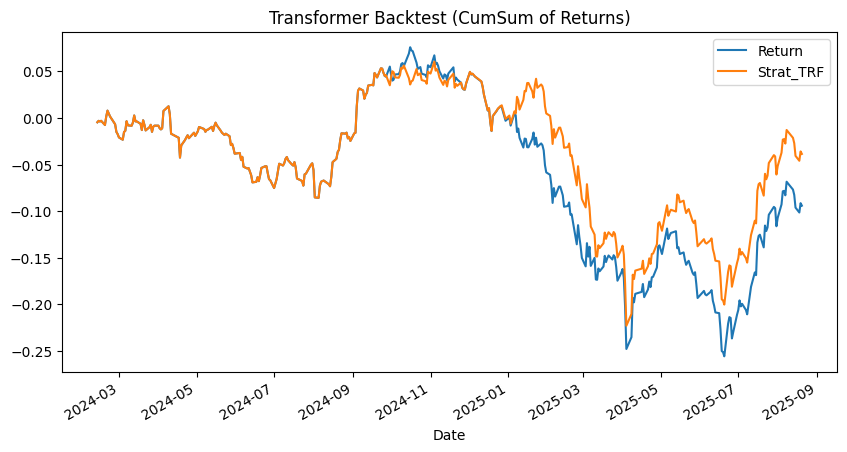

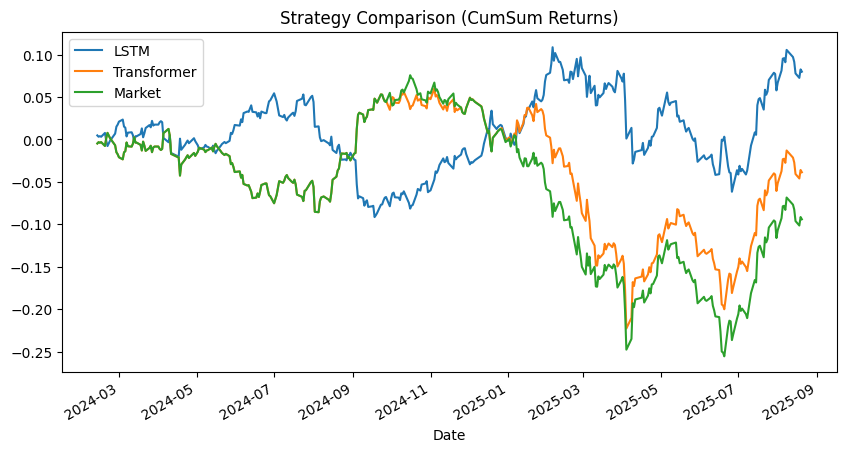

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models




def transformer_encoder(num_heads=4, key_dim=32, ff_dim=64, dropout=0.2):
    inp = layers.Input(shape=(WIN, X.shape[1]))
    # Positional encoding (simple learnable)
    pos = layers.Embedding(input_dim=5000, output_dim=X.shape[1])(tf.range(start=0, limit=WIN))
    pos = tf.expand_dims(pos, axis=0)
    x = inp + pos

    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    y = layers.Dense(ff_dim, activation="relu")(x)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(X.shape[1])(y)
    x = layers.Add()([x, y])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1)(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return m

tf_model = transformer_encoder()
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
hist = tf_model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=100, batch_size=64, callbacks=[es], verbose=0)

yhat_tf = tf_model.predict(Xte).ravel()
rmse_tf = float(np.sqrt(mean_squared_error(yte, yhat_tf)))
mae_tf  = float(mean_absolute_error(yte, yhat_tf))
r2_tf   = float(r2_score(yte, yhat_tf))
da_tf   = float((np.sign(yte) == np.sign(yhat_tf)).mean())
print({"RMSE": rmse_tf, "MAE": mae_tf, "R2": r2_tf, "DA": da_tf})

# align timeline ของ test set
# ข้อมูล test set เริ่มจาก index หลัง val + window size
# --- Rebuild LSTM backtest ---
# --- Train LSTM ---

from tensorflow.keras import layers, models

def build_lstm(input_shape, units=64, dropout=0.2):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


model = build_lstm((WIN, X.shape[1]))
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
hist = model.fit(Xtr, ytr, validation_data=(Xva, yva),
                 epochs=100, batch_size=64, callbacks=[es], verbose=0)

# --- Predict ---
yhat = model.predict(Xte).ravel()   # <= ตัวแปรนี้คือ yhat ที่ต้องใช้ต่อ


# --- LSTM backtest ---
idx_test = df.index[n_val+WIN:]   # align timeline
bt = pd.DataFrame(index=idx_test)
bt["Return"] = yte
bt["Sig_LSTM"] = np.where(yhat > 0, 1, -1)
bt["Strat_LSTM"] = bt["Sig_LSTM"] * bt["Return"]



# backtest
bt_tf = pd.DataFrame(index=idx_test)
bt_tf["Return"] = yte
bt_tf["Sig_TRF"] = np.where(yhat_tf>0, 1, -1)
bt_tf["Strat_TRF"] = bt_tf["Sig_TRF"] * bt_tf["Return"]
bt_tf[["Return","Strat_TRF"]].cumsum().plot(figsize=(10,5), title="Transformer Backtest (CumSum of Returns)")
plt.show()

# compare LSTM vs Transformer
# --- Compare LSTM vs Transformer vs Market ---
cmp = pd.DataFrame({
    "LSTM": bt["Strat_LSTM"].cumsum(),
    "Transformer": bt_tf["Strat_TRF"].cumsum(),
    "Market": bt["Return"].cumsum()
})
cmp.plot(figsize=(10,5), title="Strategy Comparison (CumSum Returns)")
plt.show()


pd.DataFrame([{"RMSE":rmse_tf,"MAE":mae_tf,"R2":r2_tf,"DA":da_tf}]).to_csv("transformer_metrics_test.csv", index=False)
bt_tf.to_csv("backtest_transformer.csv")
